# Addendum

As an extra exercise (and out of curiosity), this notebook file tests how performant the CUDA solution in Assignment 2 is compared to an equivalent NumPy or numba version of the same code, and how performance scales with $N$.

Note these values are taken using Google Colab's T4 GPU.

In [1]:
import matplotlib.pyplot as plt

def check_u(u, N):
  """The plots taken from Assignment 2, just to check if u looks correct."""
  fig = plt.figure(figsize=(12, 6))
  for subplot, time in enumerate([1, 2, 10]):
    ax = fig.add_subplot(3, 1, subplot+1)
    ax.plot(u[time*N, :])
    ax.set_xlim(0, N)
    ax.set_ylim(0)
    if subplot != 2:
      ax.set_xlabel('')
      ax.set_xticks([])

In [2]:
import numpy as np

def heat_equation(u, N, M):
  """Numpy version of the heat_equation function in Assignment 2."""
  h = 1/N
  for j in range(M):
    for x in range(N+1):
      if x == 0:
        u[j+1, x] = 10
      elif x == N:
        u[j+1, x] = 10
      else:
        u[j+1, x] = u[j, x] + (u[j, x-1] - 2*u[j, x] + u[j, x+1]) / (1000 * h)

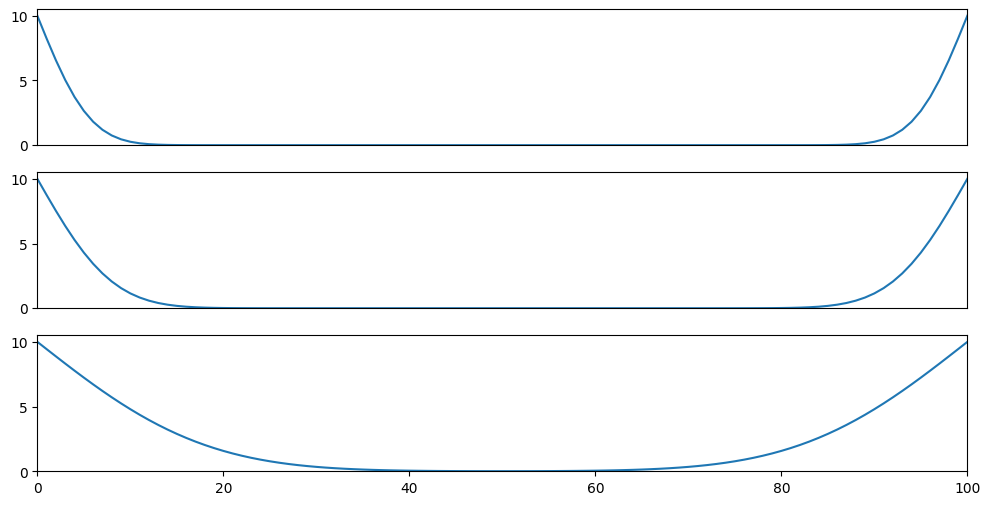

In [3]:
import numba
from numba import njit, prange

@njit(parallel=True)
def heat_equation_jit(u, N, M):
  """Parallelised CPU numba version of the heat_equation function in Assignment
  2."""
  h = 1/N
  for j in range(M):
    for x in prange(N+1):
      if x == 0:
        u[j+1, x] = 10
      elif x == N:
        u[j+1, x] = 10
      else:
        u[j+1, x] = u[j, x] + (u[j, x-1] - 2*u[j, x] + u[j, x+1]) / (1000 * h)

# compile once
u = np.zeros((1001, 101))
u[0, 0] = 10
u[0, 100] = 10
heat_equation_jit(u, 100, 1000)
# check the result is the same
check_u(u, 100)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


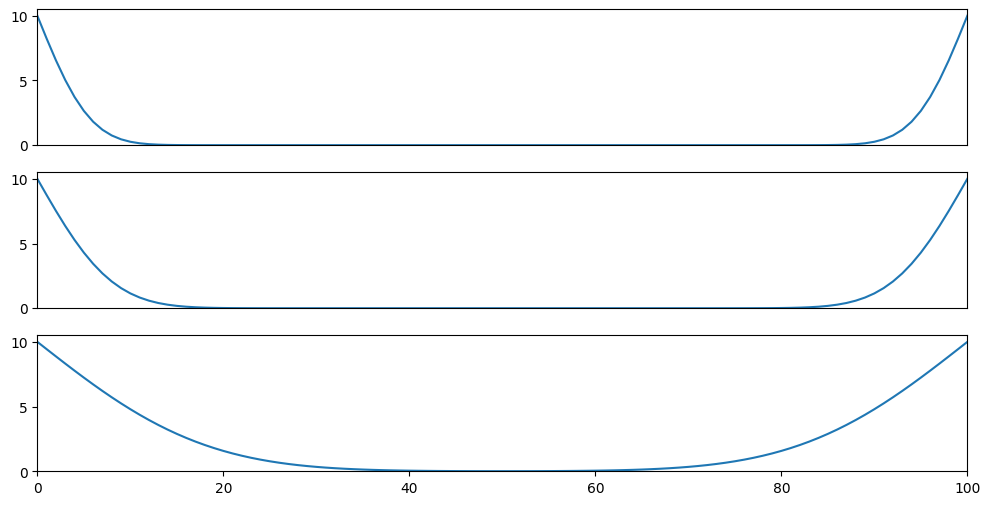

In [4]:
from numba import cuda

@cuda.jit
def heat_equation_cuda(u, N, M):
  """Modified version of the CUDA heat_equation function in Assignment 2, which
  works for variable N (max 500) and M."""
  h = 1/N
  x = cuda.grid(1)
  sh = cuda.shared.array(501, numba.float32)

  for j in range(M):
    sh[x] = u[j, x]

    cuda.syncthreads()
    if x == 0:
      u[j+1, x] = numba.float32(10)
    elif x == N:
      u[j+1, x] = numba.float32(10)
    else:
      u[j+1, x] = sh[x] + (sh[x-1] - 2*sh[x] + sh[x+1]) / numba.float32(1000 * h)
    cuda.syncthreads()

# compile this as well
u = np.zeros((1001, 101))
u[0, 0] = 10
u[0, 100] = 10
result = cuda.to_device(u.astype('float32'))
heat_equation_cuda[1, 101](result, 100, 1000)
# check the result is the same
u = result.copy_to_host()
check_u(u, 100)

In [5]:
from timeit import timeit

sizes = [5, 10, 20, 50, 100, 200, 500]
times = []
times_jit = []
times_cuda = []

for N in sizes:
  t_final = 60
  M = t_final * N

  TPB = N+1
  BPG = 1

  u = np.zeros((M+1, N+1))
  u[0, 0] = 10
  u[0, N] = 10
  times.append(timeit("heat_equation(u, N, M)",
                      "from __main__ import heat_equation, u, N, M",
                      number=1))
  times_jit.append(timeit("heat_equation_jit(u, N, M)",
                          "from __main__ import heat_equation_jit, u, N, M",
                          number=1))
  result = cuda.to_device(u.astype('float32'))
  times_cuda.append(timeit("heat_equation_cuda[BPG, TPB](result, N, M)",
                           "from __main__ import heat_equation_cuda, result, N, M, BPG, TPB",
                           number=1))


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


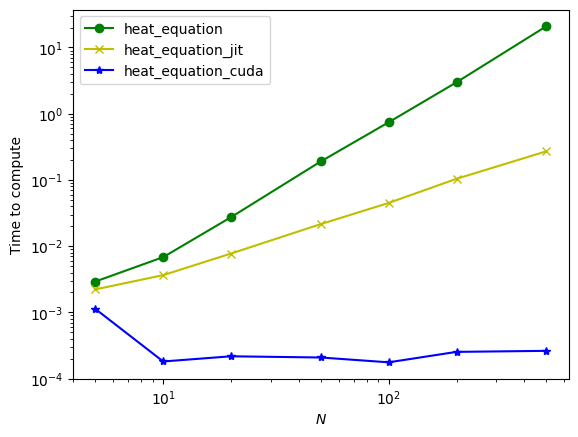

[0.002921125000000302, 0.006827474999994365, 0.027393305999993345, 0.1901689639999944, 0.7422396749999791, 2.981443583999976, 20.875929646999992]
[0.002221968999990054, 0.0036503329999959533, 0.0077377519999970445, 0.021524839000008456, 0.0449215960000231, 0.10396940600000448, 0.27028223199999957]
[0.0011283349999899883, 0.00018132099999945694, 0.00021716999999910058, 0.0002082240000049751, 0.00017606099999056823, 0.0002531439999984286, 0.0002624230000094485]


In [6]:
plt.plot(sizes, times, "go-")
plt.plot(sizes, times_jit, "yx-")
plt.plot(sizes, times_cuda, "b*-")
plt.xscale("log")
plt.yscale("log")

plt.xlabel("$N$")
plt.ylabel("Time to compute")
plt.legend(["heat_equation", "heat_equation_jit", "heat_equation_cuda"])
plt.show()

print(times)
print(times_jit)
print(times_cuda)

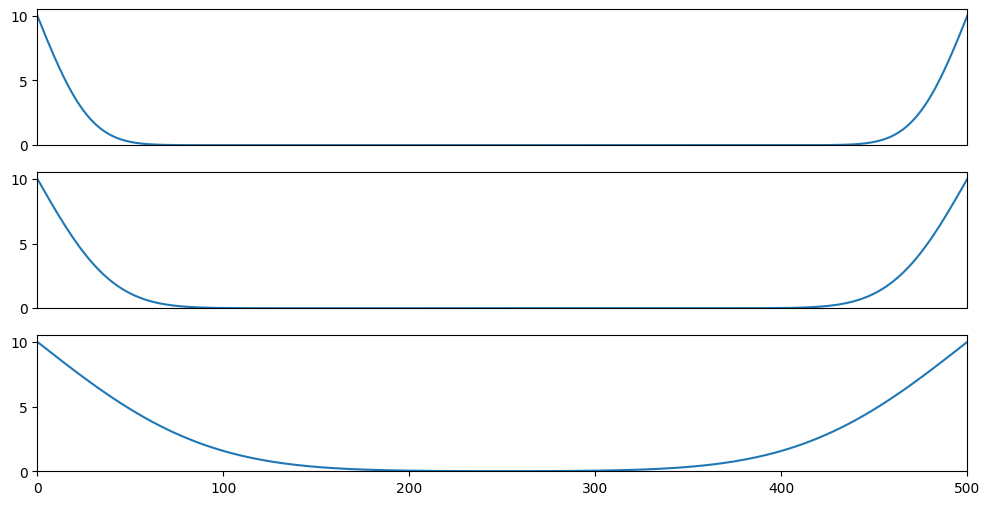

In [7]:
# last check!
u = result.copy_to_host()
check_u(u, N)